# Importing Libraries

In [1]:
# import system libraries
import os
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# import Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input, Dense
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')


# Data Preprocessing

## Read Data and store it in dataframe

In [2]:
data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)
    
    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)
        
        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)
            
            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')
            
            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')
            
            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')
            
            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')
            
            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')
                
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [3]:
df

filepaths                labels
0      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
1      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
2      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
3      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
4      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
...                                                  ...                   ...
24995  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24996  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24997  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24998  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24999  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue

[25000 rows x 2 columns]

## Split data into train, valid and test

In [4]:
strat = df['labels']
train_df, dummy_df = train_test_split(df, train_size= .8, shuffle=True, stratify=strat, random_state=123)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df  = train_test_split(dummy_df, train_size= .5, shuffle=True, stratify=strat, random_state=123)

## Create image data generator

In [5]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', 
                                       color_mode='rgb', shuffle= True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


## Show sample from train data

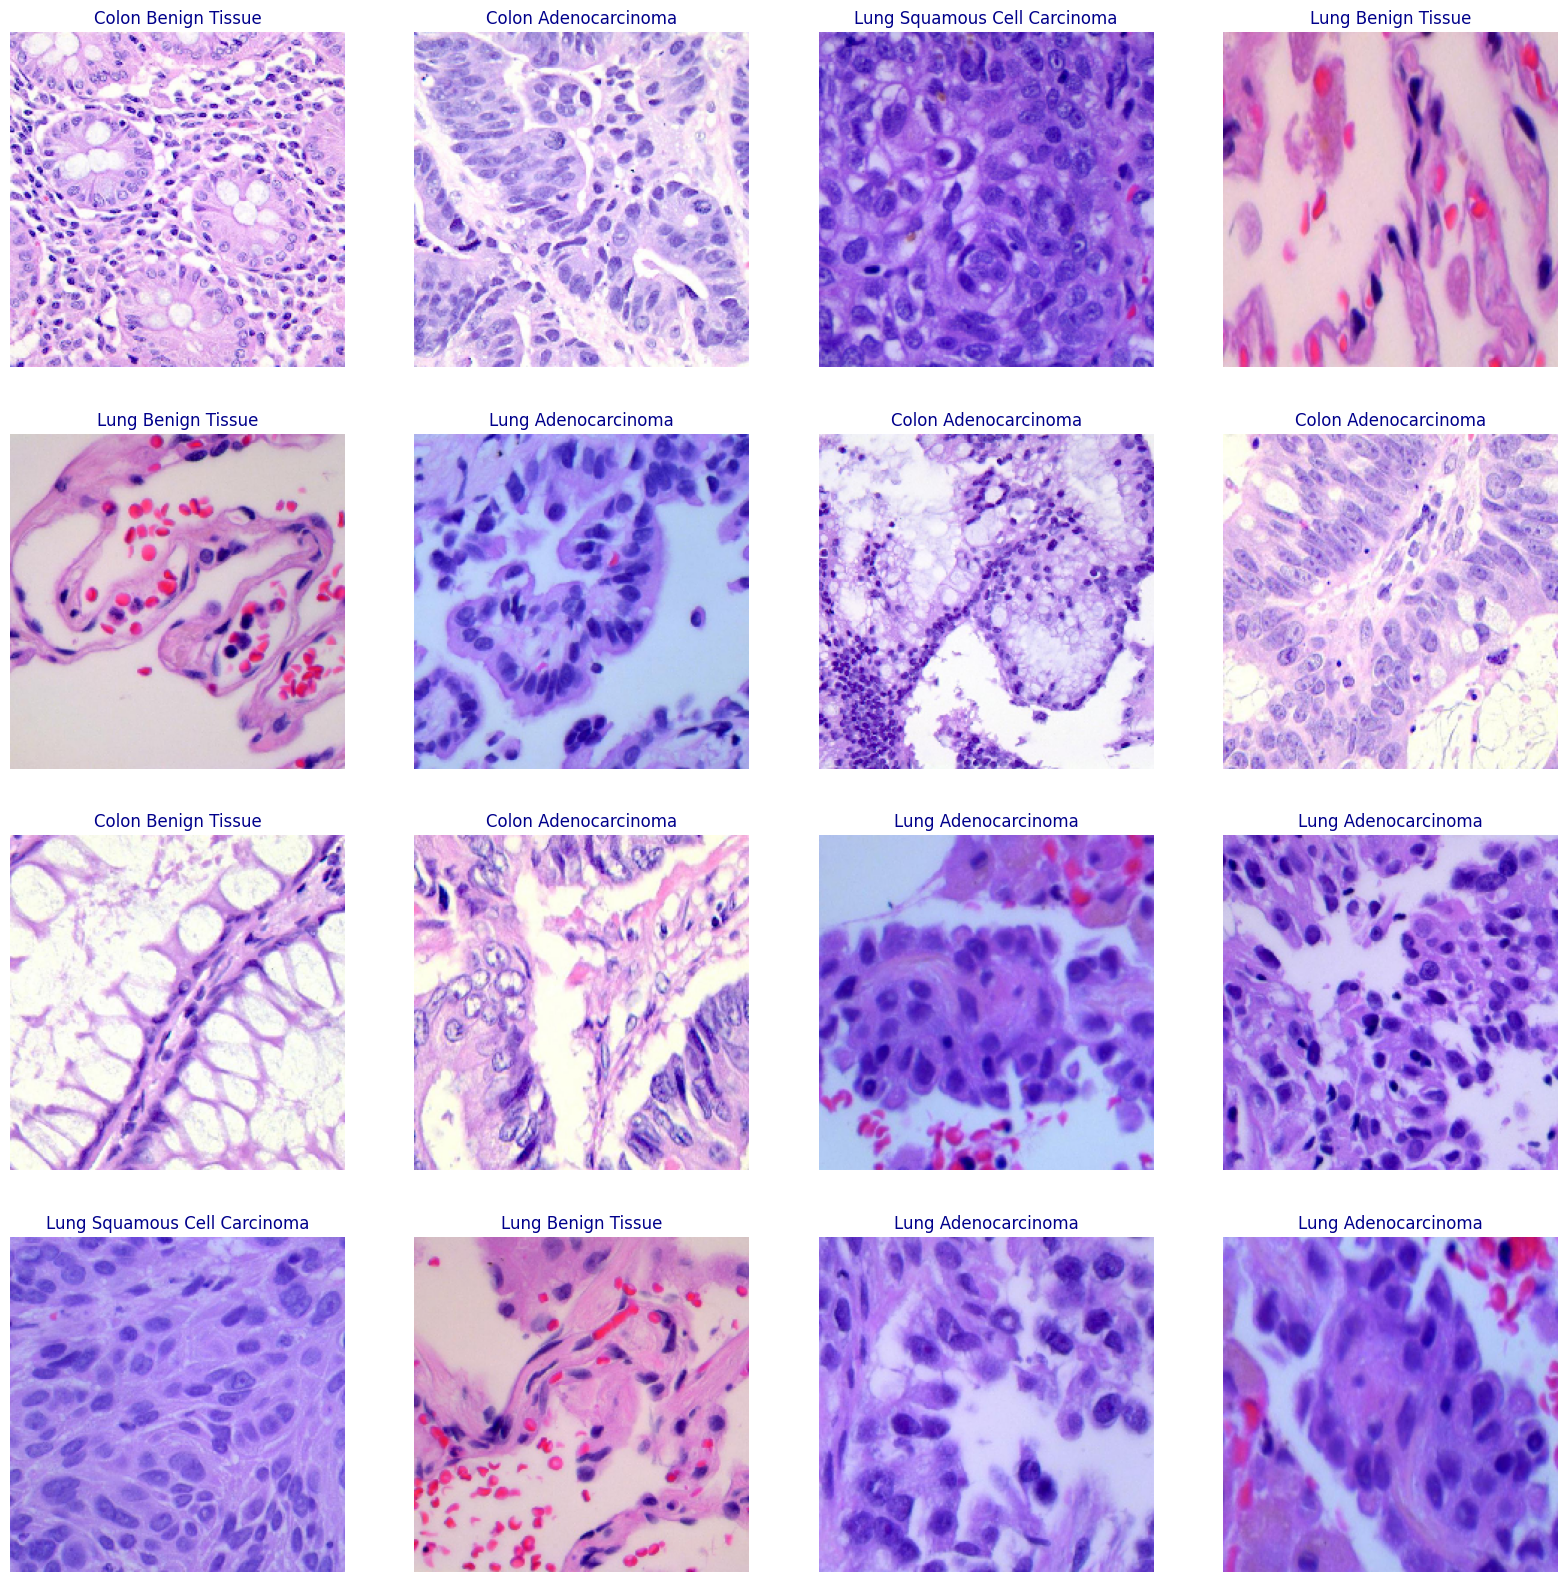

In [6]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color = 'darkblue', fontsize= 12)
    plt.axis('off')
    
plt.show()

# Model Structure

## Generic Model Creation

In [9]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([    
    Conv2D(64, (3,3), padding='same', activation='relu', input_shape= img_shape),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), padding='same', activation='relu'),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(256, (3,3), padding='same', activation='relu'),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(512, (3,3), padding='same', activation='relu'),
    Conv2D(512, (3,3), padding='same', activation='relu'),
    Conv2D(512, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(512, (3,3), padding='same', activation='relu'),
    Conv2D(512, (3,3), padding='same', activation='relu'),
    Conv2D(512, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(class_count, activation='softmax')
    
])

model.compile(Adamax(learning_rate= 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

## Train model

In [10]:
history = model.fit(x = train_gen, epochs = 20, verbose = 1, validation_data = valid_gen,
                    shuffle = False, validation_steps = None)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 249s 778ms/step - accuracy: 0.4072 - loss: 2.6487 - val_accuracy: 0.8772 - val_loss: 0.3138
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 134s 426ms/step - accuracy: 0.8728 - loss: 0.3173 - val_accuracy: 0.9340 - val_loss: 0.1611
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 132s 421ms/step - accuracy: 0.9328 - loss: 0.1765 - val_accuracy: 0.9556 - val_loss: 0.1145
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 132s 422ms/step - accuracy: 0.9446 - loss: 0.1516 - val_accuracy: 0.9548 - val_loss: 0.1129
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 421ms/step - accuracy: 0.9575 - loss: 0.1189 - val_accuracy: 0.9820 - val_loss: 0.0550
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 132s 421ms/step - accuracy: 0.9717 - loss: 0.0747 - val_accuracy: 0.9596 - val_loss: 0.0958
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 132s 422ms/step - accuracy: 0.9776 - loss: 0.0601 - val_accuracy: 0.9692 - val_loss: 0.0844
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 133s 424ms/step - accuracy: 0.9782 -

## Display model performance

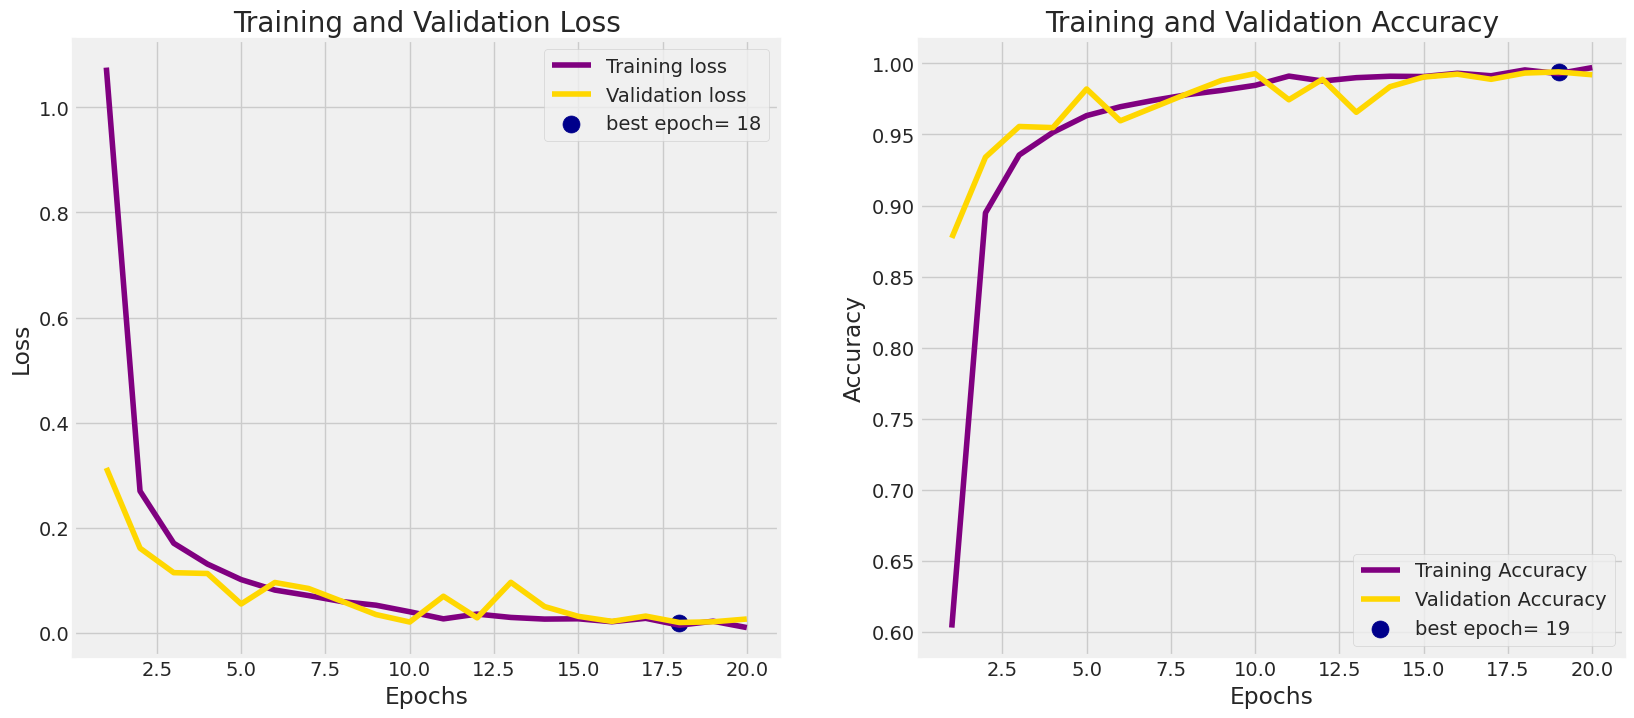

In [11]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'purple', label= 'Training loss')
plt.plot(Epochs, val_loss, 'gold', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'purple', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'gold', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate model

In [12]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 96s 306ms/step - accuracy: 0.9974 - loss: 0.0090
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 308ms/step - accuracy: 0.9913 - loss: 0.0373
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 623ms/step - accuracy: 0.9888 - loss: 0.0333
Train Loss:  0.009803523309528828
Train Accuracy:  0.9965999722480774
--------------------
Valid Loss:  0.02635250613093376
Valid Accuracy:  0.9919999837875366
--------------------
Test Loss:  0.03822118788957596
Test Accuracy:  0.9883999824523926


# Get Predictions

In [13]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 299ms/step


In [14]:
preds

array([[5.6669709e-09, 1.8629642e-09, 1.8961206e-05, 2.7208460e-10,
        9.9998105e-01],
       [9.9944621e-01, 5.4451043e-04, 8.2162924e-06, 1.0517346e-06,
        2.2474671e-08],
       [3.7785400e-12, 1.4814788e-13, 6.5639584e-11, 1.0000000e+00,
        7.8905669e-19],
       ...,
       [1.0018905e-06, 2.4100262e-09, 9.8622894e-01, 2.8731566e-07,
        1.3769758e-02],
       [1.9999490e-05, 3.7654913e-06, 6.4803980e-04, 1.7902918e-06,
        9.9932641e-01],
       [8.8006761e-13, 5.9348197e-14, 5.7302418e-12, 1.0000000e+00,
        2.6696383e-19]], dtype=float32)

## Confusion Matrics and Classification Report

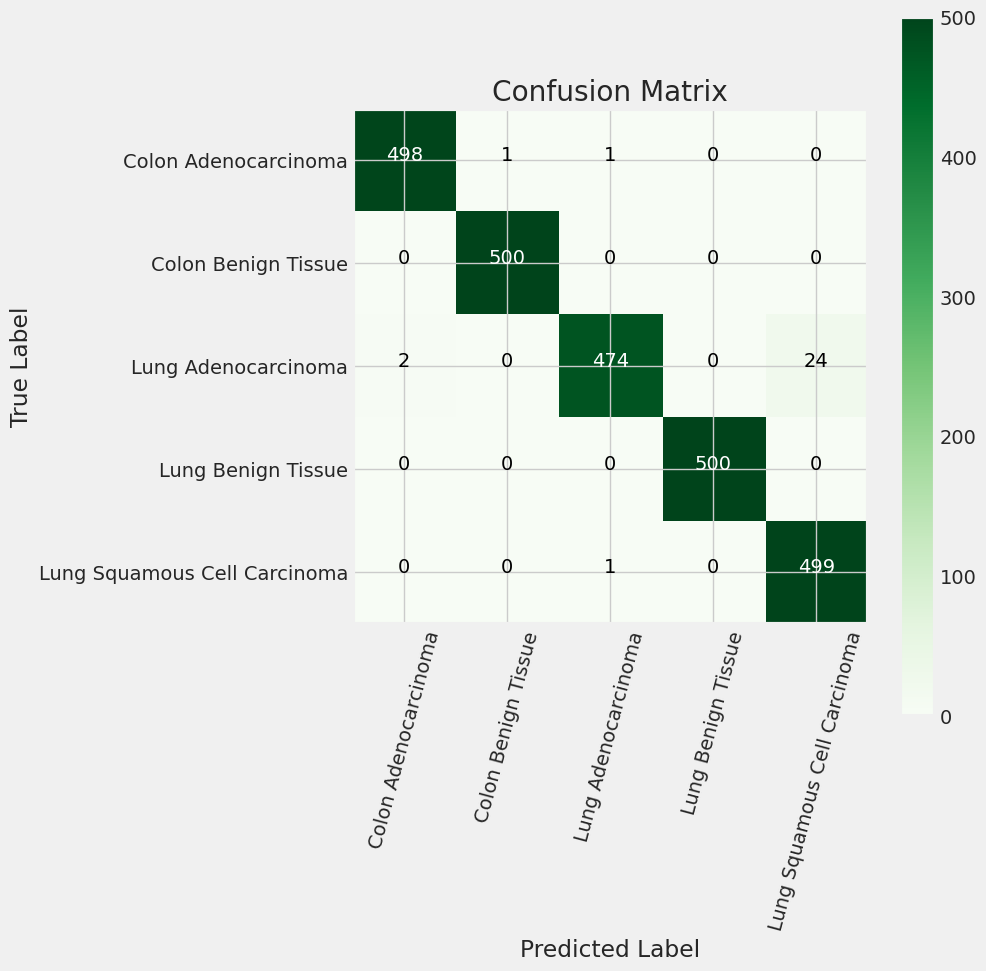

In [28]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 75)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [29]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       1.00      1.00      1.00       500
         Colon Benign Tissue       1.00      1.00      1.00       500
         Lung Adenocarcinoma       1.00      0.95      0.97       500
          Lung Benign Tissue       1.00      1.00      1.00       500
Lung Squamous Cell Carcinoma       0.95      1.00      0.98       500

                    accuracy                           0.99      2500
                   macro avg       0.99      0.99      0.99      2500
                weighted avg       0.99      0.99      0.99      2500



## Save model

In [31]:
#Save the model
model.save('Model.h5')

# Prediction using loaded_model

In [33]:
loaded_model = tf.keras.models.load_model('/kaggle/working/Model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
image_path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n/colonn1007.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224,224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f'Name of Cancer is {class_labels[np.argmax(score)]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Name of Cancer is Colon Benign Tissue
